In [1]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 18.3 MB/s eta 0:00:00


In [2]:
from unsloth import FastVisionModel
import torch

In [3]:
fourbit_models= [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit"
]

In [4]:
model, tokenizer= FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit= True,
    use_gradient_checkpointing= "unsloth"
)

==((====))==  Unsloth 2025.11.3: Fast Qwen2_Vl patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


<string>:45: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.


model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [5]:
model= FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers= True,
    finetune_language_layers= True,
    finetune_attention_modules= True,
    finetune_mlp_modules= True,

    r=16,
    lora_alpha= 16,
    lora_dropout= 0,
    bias= "none",
    random_state= 34087,
    use_rslora= False,
    loftq_config= None
)

Unsloth: Making `model.base_model.model.model.visual` require gradients


In [6]:
from datasets import load_dataset
dataset= load_dataset("unsloth/Latex_OCR", split= "train")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

In [7]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

In [9]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>,
 'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}

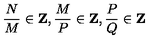

In [11]:
dataset[0]["image"]

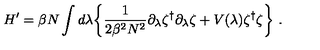

In [12]:
dataset[2]["image"]

In [13]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

In [14]:
instruction= "Write the Latex representation for this image"

In [16]:
def convert_to_conversation(sample):
  conversation= [
      {"role": "user",
       "content": [
           {"type": "text", "text": instruction},
           {"type": "image", "image": sample["image"]}

       ]},
      {"role": "assistant",
       "content": [
           {"type": "text", "text": sample["text"]}
       ]}
  ]
  return {"messages": conversation}

In [17]:
convert_to_conversation(dataset[2])

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the Latex representation for this image'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=320x50>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'}]}]}

In [18]:
converted_dataset= [convert_to_conversation(sample) for sample in dataset]

In [19]:
converted_dataset[9]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the Latex representation for this image'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=280x50>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'u _ { \\mathrm { t o t } } = { \\frac { 1 } { a ^ { 4 } } } \\sum _ { i } \\left[ \\alpha _ { i } \\ln ( a / L _ { \\mathrm { P l } } ) + \\gamma _ { i } \\right] \\approx { \\frac { \\gamma _ { \\mathrm { e f f } } } { a ^ { 4 } } } ,'}]}]}

In [21]:
image= dataset[1]["image"]
messages= [
  {"role": "user",
   "content": [
       {"type": "text", "text": instruction},
       {"type": "image", "image": image}
   ]}
]

In [23]:
input_text= tokenizer.apply_chat_template(messages, add_generation_prompt= True)
inputs= tokenizer(
    image,
    input_text,
    add_special_tokens= False,
    return_tensors= "pt"
).to("cuda")

In [24]:
from transformers import TextStreamer
text_streamer= TextStreamer(tokenizer, skip_prompt= True)
_ = model.generate(**inputs, streamer= text_streamer, max_new_tokens= 128, use_cache= True, temperature= 1.5, min_p= 0.1)

The Latex representation for the image is:

\[ D_{\mu}^A \tilde{A}_{\mu}^B = 0 \]<|im_end|>


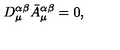

In [25]:
image

In [27]:
dataset[1]["text"]

'D _ { \\mu } ^ { \\alpha \\beta } \\bar { A } _ { \\mu } ^ { \\alpha \\beta } = 0 ,'

In [28]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

In [29]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=Fals

In [30]:
trainer= SFTTrainer(
    model= model,
    tokenizer= tokenizer,
    data_collator= UnslothVisionDataCollator(model, tokenizer),
    train_dataset= converted_dataset,
    args= SFTConfig(
        per_device_train_batch_size= 2,
        gradient_accumulation_steps= 4,
        warmup_steps= 5,
        max_steps= 30,
        learning_rate= 2e-4,
        fp16= not is_bf16_supported(),
        bf16= is_bf16_supported(),
        logging_steps= 1,
        optim= "adamw_8bit",
        weight_decay= 0.01,
        lr_scheduler_type= "linear",
        seed= 3407,
        output_dir= "outputs",
        report_to= "none",
        remove_unused_columns= False,
        dataset_text_field= "",
        dataset_kwargs= {"skip_prepare_dataset": True},
        dataset_num_proc= 4,
        max_seq_length= 2048
        )
)

Unsloth: Model does not have a default image size - using 512


In [31]:
trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936 of 8,342,231,552 (0.61% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.166100
2,1.299300
3,1.401200
4,0.970300
5,0.875500
6,0.877400
7,0.710400
8,0.471000
9,0.291200
10,0.305500


TrainOutput(global_step=30, training_loss=0.3812268850704034, metrics={'train_runtime': 374.8933, 'train_samples_per_second': 0.64, 'train_steps_per_second': 0.08, 'total_flos': 1661933681209344.0, 'train_loss': 0.3812268850704034, 'epoch': 0.0034941618379291267})

In [55]:
image= dataset[9]["image"]

In [33]:
instruction

'Write the Latex representation for this image'

In [56]:
messages

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'Write the Latex representation for this image'},
   {'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x50>}]}]

In [57]:
input_text= tokenizer.apply_chat_template(messages, add_generation_prompt= True)
inputs= tokenizer(
    image,
    input_text,
    add_special_tokens= False,
    return_tensors= "pt"
).to("cuda")

In [58]:
from transformers import TextStreamer
text_streamer= TextStreamer(tokenizer, skip_prompt= True)
_ = model.generate(**inputs, streamer= text_streamer, max_new_tokens= 128, use_cache= True, temperature= 1.5, min_p= 0.1)

u _ { \mathrm { k o t } } = \frac { 1 } { a ^ { 4 } } \sum _ { i } [ \alpha _ { i } \ln ( a / L _ { \mathrm { P 1 } } ) + \gamma _ { i } ] \approx \frac { \gamma _ { \mathrm { e f f } } } { a ^ { 4 } } ,<|im_end|>


In [59]:
dataset[9]["text"]

'u _ { \\mathrm { t o t } } = { \\frac { 1 } { a ^ { 4 } } } \\sum _ { i } \\left[ \\alpha _ { i } \\ln ( a / L _ { \\mathrm { P l } } ) + \\gamma _ { i } \\right] \\approx { \\frac { \\gamma _ { \\mathrm { e f f } } } { a ^ { 4 } } } ,'

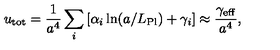

In [60]:
image

In [45]:
model.save_pretrained("Qwen_finetuned_model")